In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import sys
from pathlib import Path
import os

import matplotlib.pyplot as plt
import matplotlib as mpl

# import custom functions from src folder
module_path = str(Path.cwd() / "../../src")

if module_path not in sys.path:
    sys.path.append(module_path)

from util import *

In [2]:
#Data constants
R2 = 3
k_red = 7
k_blue = 3
R1_min = 6
scale = 1
vary_a1 = False
vary_R2 = False
p_red = 0.5
polar = False
tag = f'r2_{R2}_kr{k_red}_kb{k_blue}_r1min{R1_min}_s{scale}_vary_r2_{vary_R2}_vary_a1_{vary_a1}_pRed_{p_red}'

trainfile = f"train_n_50000_{tag}"
testfile = f"test_n_10000_{tag}"

model_names = ["NNE", 
               "CL", 
               "MCD", 
               "BNN", 
               #"GP", 
               "MM"]
pred_keys = ["Prediction_ensemble", 
             "Prediction_ensemble", 
             "Prediction_MC", 
             "Prediction",
             #"Prediction", 
             "Inferred_class"]
prob_keys = ["Confidence_avg", 
             "Confidence_avg", 
             "Confidence_MC", 
             "Est_prob_blue", 
             #"Est_prob_blue", 
             "Est_prob_blue"]
std_keys = ["Confidence_std", 
            "Confidence_std", 
            "Std_MC", 
            "Std_prob_blue", 
            #"Sigmoid_std_logit_blue", 
            "Std_samples_blue"]
n_models = len(model_names)
train_data = [250, 500, 1000, 2000, 3000, 5000, 10000]
n_plots = len(train_data)

truthfile = f"analytical_solution_x1_x2_grid_{tag}_nr1MC_4000"
truthfile_test = "analytical_solution_test_n_10000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_nr1MC_8000"
truth_data = pd.read_csv(f"analytical/results/{truthfile}.csv")
truth_data = truth_data[truth_data["r_x"] > R1_min-R2] # Remove undefined area
truth_test_data = pd.read_csv(f"analytical/results/{truthfile_test}.csv")

max_err_val = [0]*n_plots
for i in range(len(train_data)):
    if train_data[i] < 1000:
        max_err_val[i] = 0.5
    else:
        max_err_val[i] = 0.25

bnn_lr_list = [0.028, 0.028, 0.05, 0.05, 0.05, 0.05, 0.05]

#pd.read_csv("DNN/predictions/train_n_50000_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5/grid_r2_3_kr7_kb3_r1min6_s1_vary_r2_False_vary_a1_False_pRed_0.5_predicted_SequentialNet_10ensembles_ndata-100.csv")

gridfiles = [
    [f"DNN/predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_best_10ensembles_ndata-{n}.csv" for n in train_data],
    [f"DNN/predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_CL_10ensembles_ndata-{n}.csv" for n in train_data],
    [f"DNN/predictions/{trainfile}/grid_{tag}_predicted_SequentialNet_small_MCD_pd0.3_nMC_200_Vndata-{n}.csv" for n in train_data],
    [f"BNN/predictions/{trainfile}/grid_{tag}_predicted_BNN_lr{lr}_sp0.1_ndata-{n}.csv" for (lr, n) in zip(bnn_lr_list, train_data)],
    #[f"gaussian_process/predictions/{trainfile}/grid_{tag}_predicted_latentGP_0.5_ls0.2_ndata-{n}.csv" for n in train_data],
    [f"inferno/predictions/{trainfile}/grid_{tag}_predicted_MM_nsamples1200_nchains10_ndata-{n}.csv" for n in train_data]
]

testfiles = [
    [f"DNN/predictions/{trainfile}/{testfile}_predicted_SequentialNet_best_10ensembles_ndata-{n}.csv" for n in train_data],
    [f"DNN/predictions/{trainfile}/{testfile}_predicted_SequentialNet_CL_10ensembles_ndata-{n}.csv" for n in train_data],
    [f"DNN/predictions/{trainfile}/{testfile}_predicted_SequentialNet_small_MCD_pd0.3_nMC_200_Vndata-{n}.csv" for n in train_data],
    [f"BNN/predictions/{trainfile}/{testfile}_predicted_BNN_lr{lr}_sp0.1_ndata-{n}.csv" for (lr, n) in zip(bnn_lr_list, train_data)],
    #[f"gaussian_process/predictions/{trainfile}/{testfile}_predicted_latentGP_0.5_ls0.2_ndata-{n}.csv" for n in train_data],
    [f"inferno/predictions/{trainfile}/{testfile}_predicted_MM_nsamples1200_nchains10_ndata-{n}.csv" for n in train_data]
]

grid_dfs = [[pd.read_csv(gridfiles[i][j]) for j in range(n_plots)]for i in range(n_models)]
test_dfs = [[pd.read_csv(testfiles[i][j]) for j in range(n_plots)]for i in range(n_models)]

for i in range(n_plots):
    test_dfs[2][i]["class"] = test_dfs[0][i]["class"]

scores = [calculate_metrics(test_dfs[i], grid_dfs[i], train_data, truth_data, truth_test_data, 
                           pred_keys[i], prob_keys[i], std_keys[i]) for i in range(n_models)]

scores_small = [calculate_metrics(test_dfs[i], grid_dfs[i], train_data, truth_data, truth_test_data, 
                           pred_keys[i], prob_keys[i], std_keys[i], n_max=500) for i in range(n_models)]

In [3]:
# Max accuracy on test set
print(truth_test_data[[f"P_blue_given_x", f"P_red_given_x"]].max(axis=1))
max_acc = np.sum(truth_test_data[[f"P_blue_given_x", f"P_red_given_x"]].max(axis=1))/len(truth_test_data)
print(max_acc)

0       0.602990
1       0.840724
2       0.718877
3       0.854740
4       0.698780
          ...   
9195    0.656671
9196    0.662191
9197    0.518197
9198    0.859482
9199    0.655207
Length: 9200, dtype: float64
0.7406950405842412


In [4]:
for i in range (n_models):
    print(model_names[i])
    print(scores[i])

NNE
   N data       ACC    ROCAUC   WD test   WD grid    Avg UE    Std UE  \
0     250  0.708171  0.786493  0.078488  0.022722  0.052622  0.036316   
1     500  0.720072  0.804750  0.048837  0.012578  0.032096  0.018510   
2    1000  0.729773  0.814434  0.032304  0.019094  0.043559  0.018057   
3    2000  0.737374  0.817205  0.027936  0.016626  0.044861  0.018129   
4    3000  0.739274  0.818096  0.024106  0.016055  0.055201  0.025939   
5    5000  0.740574  0.819781  0.019643  0.014349  0.050824  0.025526   
6   10000  0.742474  0.821011  0.009488  0.009657  0.052500  0.030450   

   Mean KL-div test  Mean KL-div grid   LogLoss       ECE       MCE     RMSCE  
0          0.067506          0.030602  0.605911  0.100903  0.158759  0.109731  
1          0.031596          0.010307  0.539428  0.049212  0.114884  0.060057  
2          0.018281          0.005098  0.520438  0.028414  0.074818  0.033955  
3          0.015301          0.003017  0.517205  0.025475  0.062743  0.031955  
4          

In [5]:
keys = ["N data", "ACC", "ROCAUC", "LogLoss", "Mean KL-div test", "ECE", "WD test"]
best_score = pd.DataFrame(columns=keys)
best_score["N data"] = train_data

for i in range(n_plots):
    #Metrics that should be maximized
    for key in (["ACC", "ROCAUC"]):
        best_score.loc[i, key] = np.argmax([scores[j][key][i] for j in range(n_models)])
    for key in (["LogLoss", "Mean KL-div test", "ECE", "WD test"]):
        best_score.loc[i, key] = np.argmin([scores[j][key][i] for j in range(n_models)])
print(best_score)

   N data ACC ROCAUC LogLoss Mean KL-div test ECE WD test
0     250   2      2       2                2   3       3
1     500   3      2       2                3   0       0
2    1000   2      2       0                2   0       0
3    2000   4      2       0                0   0       0
4    3000   4      2       0                0   0       0
5    5000   4      2       0                1   0       0
6   10000   3      2       0                1   0       0


In [6]:
keys = ["N data", "ACC", "ROCAUC", "LogLoss", "Mean KL-div test", "ECE", "WD test"]
best_score_small = pd.DataFrame(columns=keys)
best_score_small["N data"] = train_data

for i in range(n_plots):
    #Metrics that should be maximized
    for key in (["ACC", "ROCAUC"]):
        best_score_small.loc[i, key] = np.argmax([scores_small[j][key][i] for j in range(n_models)])
    for key in (["LogLoss", "Mean KL-div test", "ECE", "WD test"]):
        best_score_small.loc[i, key] = np.argmin([scores_small[j][key][i] for j in range(n_models)])
print(best_score_small)

   N data ACC ROCAUC LogLoss Mean KL-div test ECE WD test
0     250   2      3       3                2   3       3
1     500   3      2       2                3   0       0
2    1000   0      2       2                2   0       2
3    2000   4      0       0                0   0       0
4    3000   2      4       3                0   0       0
5    5000   3      2       1                0   0       0
6   10000   3      2       0                0   0       0


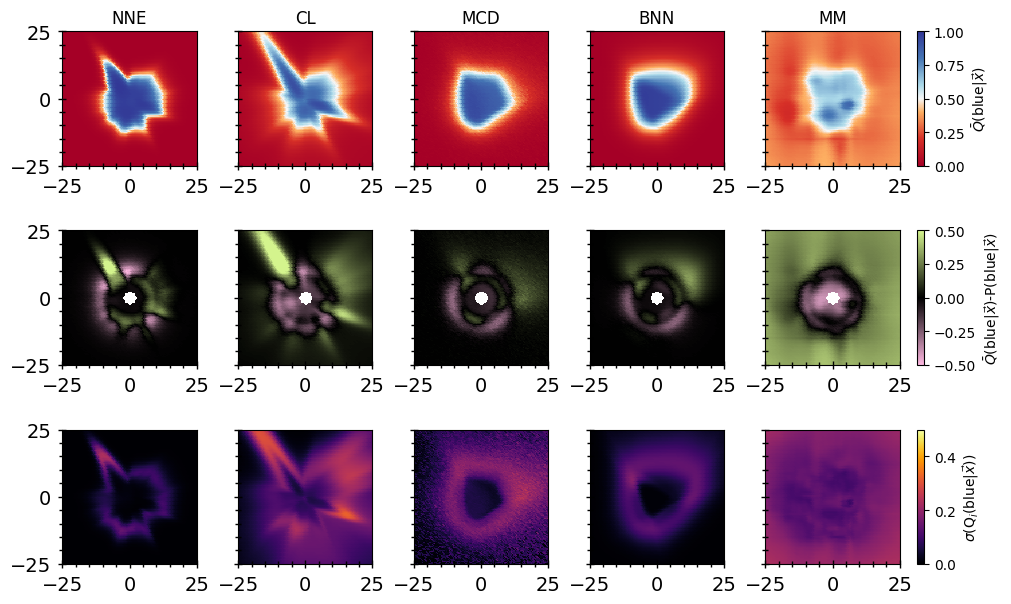

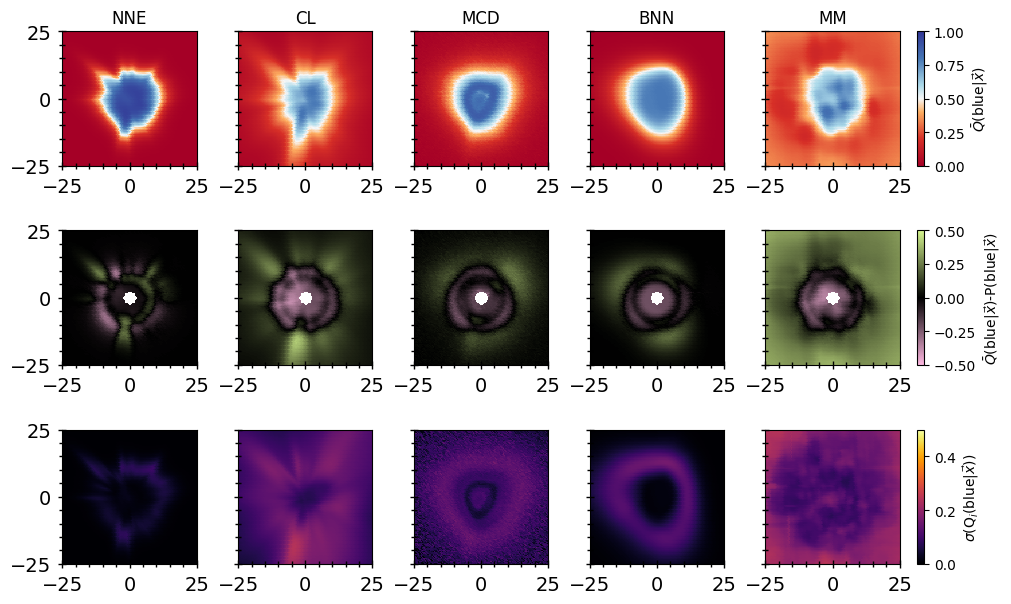

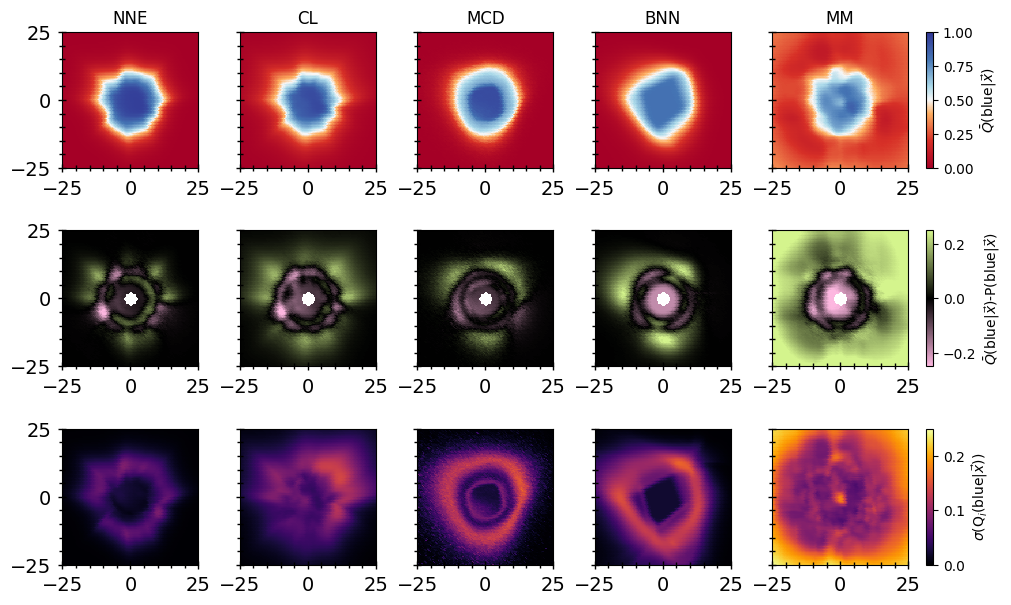

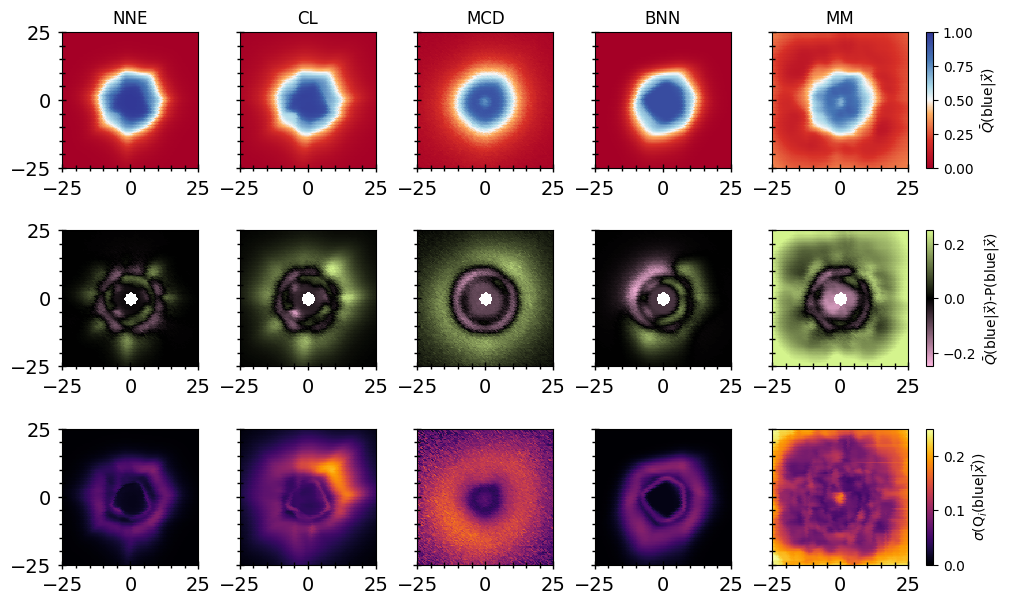

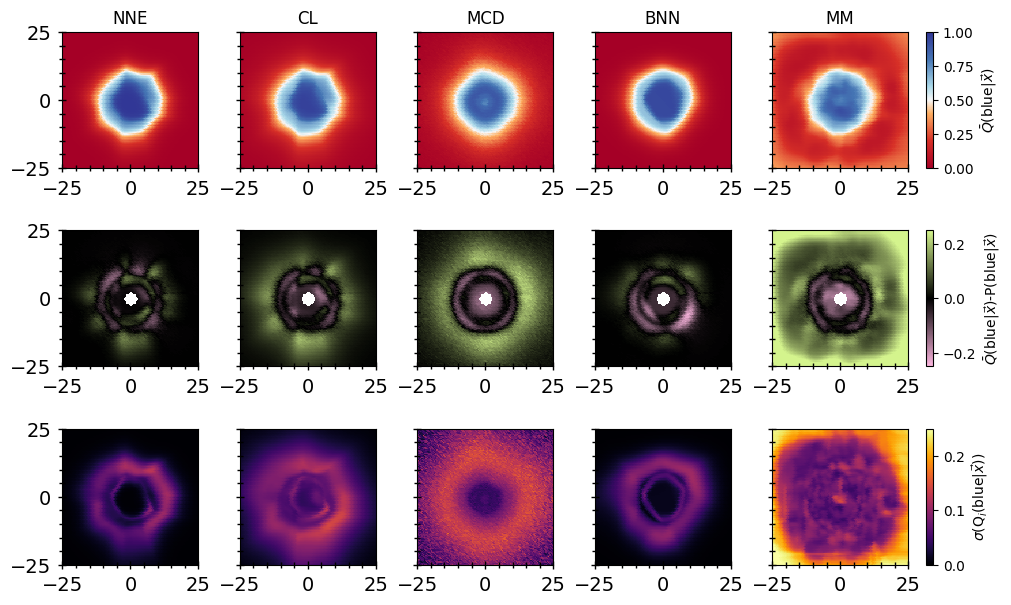

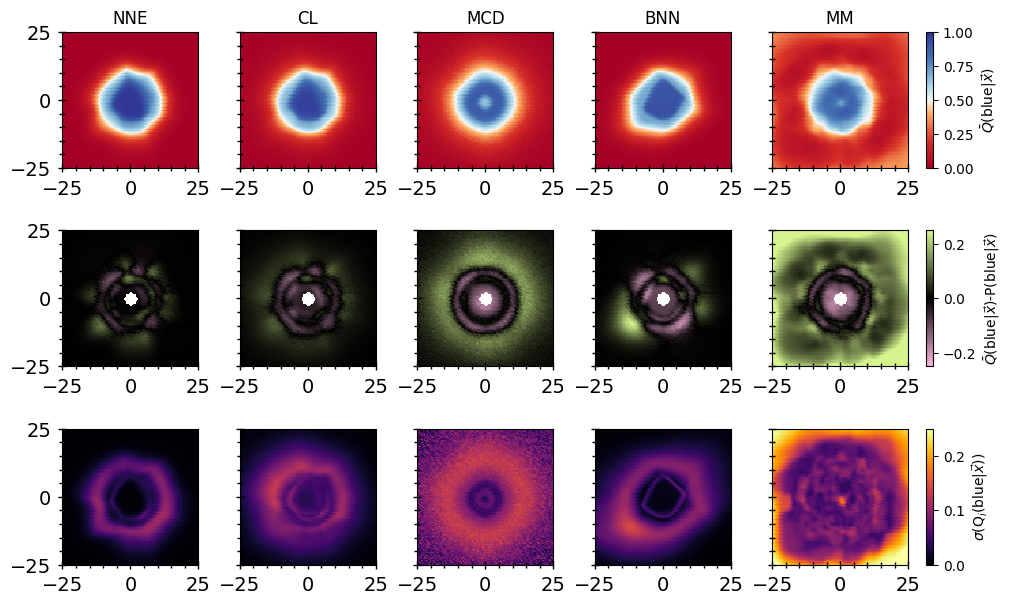

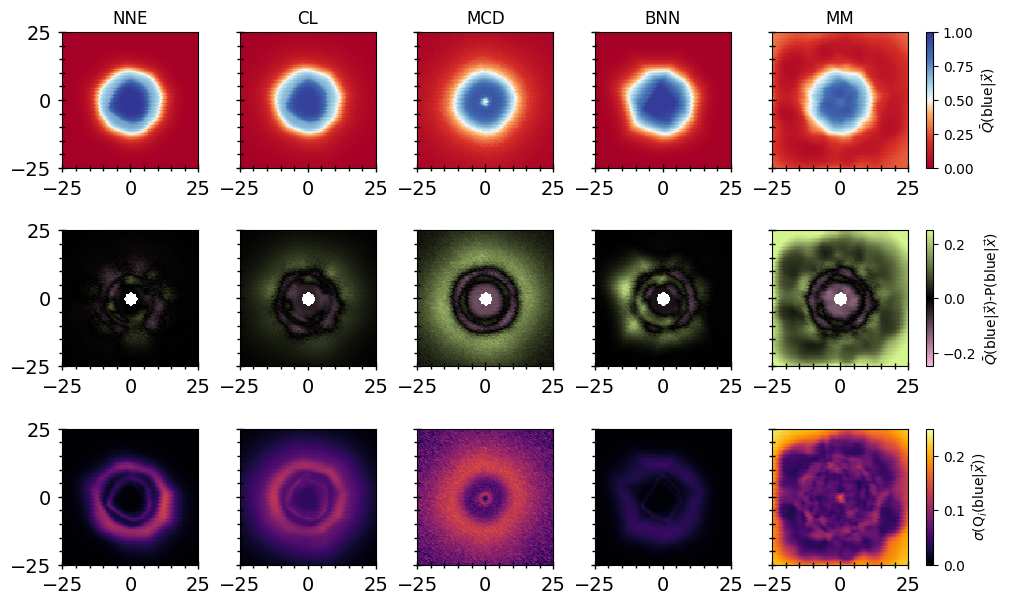

In [7]:
for i in range(n_plots):
    fig, axs = plt.subplots(nrows = 3, ncols = n_models, figsize = (2*n_models,6), layout="constrained", sharey=True)
    for j in range(n_models):
        axs[0][j] = plot_results(grid_dfs[j][i], prob_keys[j], axs[0][j], "", grid=True)
        axs[1][j] = plot_diff(grid_dfs[j][i], truth_data, prob_keys[j], "P_blue_given_x",  axs[1][j], r"", max_val=max_err_val[i])
        axs[2][j] = plot_std(grid_dfs[j][i], std_keys[j], axs[2][j], r"", grid=True, max_val=max_err_val[i])
        
        axs[0][j].set_title(model_names[j])

    hue_norm_prob = mpl.colors.Normalize(vmin=0, vmax=1, clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_prob, cmap=red_blue_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)", ax=axs[0][-1])
    
    hue_norm_err = mpl.colors.Normalize(vmin=0, vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_err, cmap="inferno"),  fraction=0.050, pad=0.04,
                label=r"$\sigma$(Q$_i$(blue|$\vec{x}$))", ax=axs[2][-1])
    
    hue_norm_std = mpl.colors.Normalize(vmin=-max_err_val[i], vmax=max_err_val[i], clip=False)
    fig.colorbar(mpl.cm.ScalarMappable(norm=hue_norm_std, cmap=pink_black_green_cmap()),  fraction=0.050, pad=0.04,
                 label=r"$\bar{Q}$(blue|$\vec{x}$)-P(blue|$\vec{x}$)", ax=axs[1][-1])
    #fig.savefig(f"fig/results_grid_{train_data[i]}.pdf", format="pdf", bbox_inches='tight', dpi=350)
    

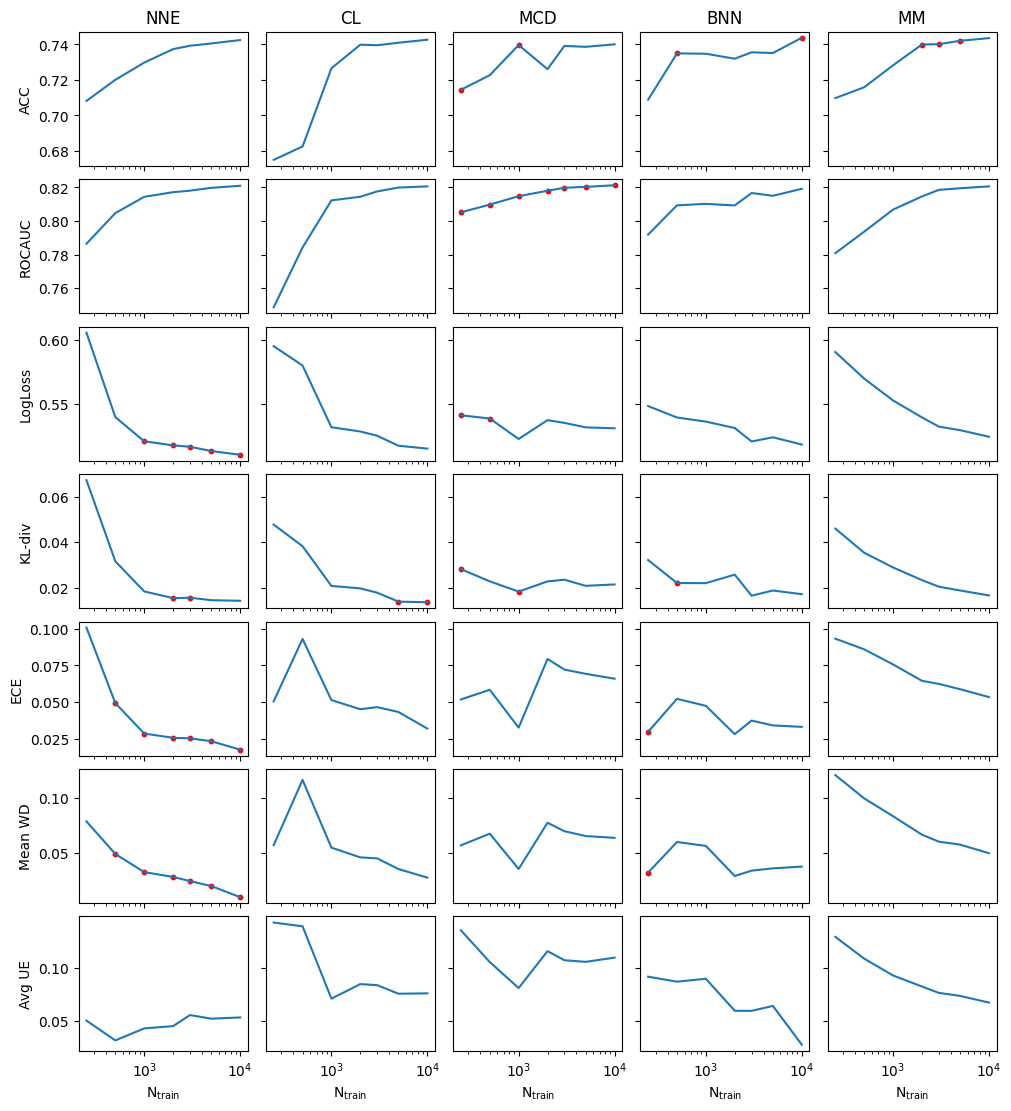

In [12]:
metric_keys = ["ACC", "ROCAUC", "LogLoss", "Mean KL-div test", "ECE", "WD test", "Avg UE"]
fig, axs = plt.subplots(nrows = 7, ncols = n_models, figsize = (2*n_models,11), layout="constrained", sharex=True, sharey="row")
for i in range(n_models):
    axs[0][i].set_title(model_names[i])
    
    axs[0][i].plot(scores[i]["N data"], scores[i]["ACC"])
    #axs[0][i].set_ylim(0.6, 0.8)
    axs[0][0].set_ylabel("ACC")

    axs[1][i].plot(scores[i]["N data"], scores[i]["ROCAUC"])
    #axs[1][i].set_ylim(0.7, 1)
    axs[1][0].set_ylabel("ROCAUC")

    axs[2][i].plot(scores[i]["N data"], scores[i]["LogLoss"])
    #axs[2][i].set_ylim(0.4, 0.7)
    axs[2][0].set_ylabel("LogLoss")

    axs[3][i].plot(scores[i]["N data"], scores[i]["Mean KL-div test"])
    #axs[5][i].set_ylim(0, 0.08)
    axs[3][0].set_ylabel("KL-div")

    axs[4][i].plot(scores[i]["N data"], scores[i]["ECE"])
    #axs[3][i].set_ylim(0, 0.1)
    axs[4][0].set_ylabel("ECE")

    axs[5][i].plot(scores[i]["N data"], scores[i]["WD test"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[5][0].set_ylabel("Mean WD")

    axs[6][i].plot(scores[i]["N data"], scores_small[i]["Avg UE"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[6][0].set_ylabel("Avg UE")

    for col in axs[-1]:
        col.set_xlabel(r"N$_{\text{train}}$")

    for ax in axs.flatten():
        ax.set_xscale("log")


for j in range(len(metric_keys)-1):
    for n in range(n_plots):
        key = metric_keys[j]
        best_model = best_score[metric_keys[j]][n]
        axs[j, best_model].scatter(x=[train_data[n]], y=[scores[best_model][key][n]], marker='o', s=10, c="red")


#fig.savefig(f"fig/results_metrics.pdf", format="pdf", bbox_inches='tight', dpi=350)

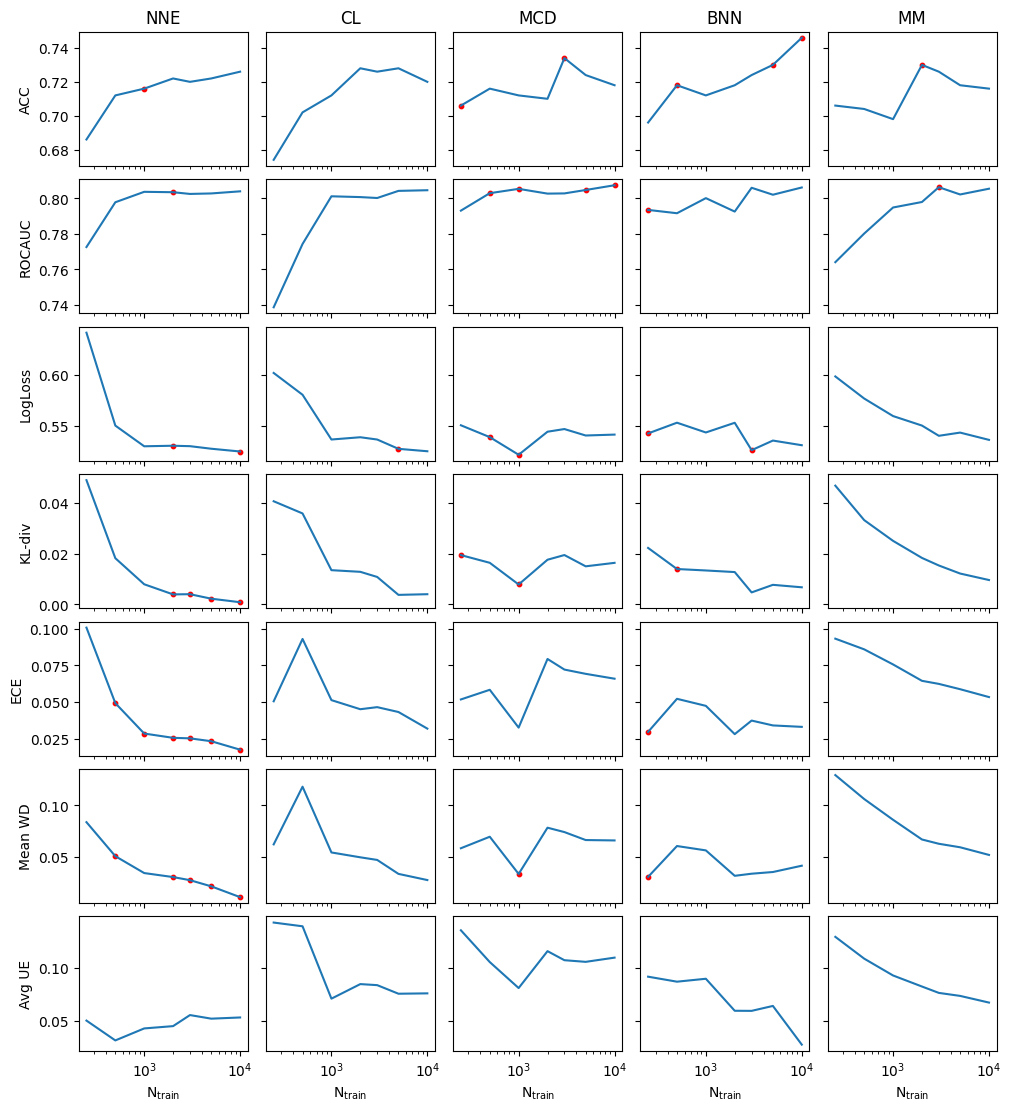

In [13]:
fig, axs = plt.subplots(nrows = 7, ncols = n_models, figsize = (2*n_models,11), layout="constrained", sharex=True, sharey="row")
for i in range(n_models):
    axs[0][i].set_title(model_names[i])
    
    axs[0][i].plot(scores_small[i]["N data"], scores_small[i]["ACC"])
    #axs[0][i].set_ylim(0.6, 0.8)
    axs[0][0].set_ylabel("ACC")

    axs[1][i].plot(scores_small[i]["N data"], scores_small[i]["ROCAUC"])
    #axs[1][i].set_ylim(0.7, 1)
    axs[1][0].set_ylabel("ROCAUC")

    axs[2][i].plot(scores_small[i]["N data"], scores_small[i]["LogLoss"])
    #axs[2][i].set_ylim(0.4, 0.7)
    axs[2][0].set_ylabel("LogLoss")

    axs[3][i].plot(scores_small[i]["N data"], scores_small[i]["Mean KL-div test"])
    #axs[5][i].set_ylim(0, 0.08)
    axs[3][0].set_ylabel("KL-div")

    axs[4][i].plot(scores_small[i]["N data"], scores_small[i]["ECE"])
    #axs[3][i].set_ylim(0, 0.1)
    axs[4][0].set_ylabel("ECE")

    axs[5][i].plot(scores_small[i]["N data"], scores_small[i]["WD test"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[5][0].set_ylabel("Mean WD")

    axs[6][i].plot(scores_small[i]["N data"], scores_small[i]["Avg UE"])
    #axs[4][i].set_ylim(0, 0.15)
    axs[6][0].set_ylabel("Avg UE")

    for col in axs[-1]:
        col.set_xlabel(r"N$_{\text{train}}$")

    for ax in axs.flatten():
        ax.set_xscale("log")


for j in range(len(metric_keys)-1):
    for n in range(n_plots):
        key = metric_keys[j]
        best_model = best_score_small[metric_keys[j]][n]
        axs[j, best_model].scatter(x=[train_data[n]], y=[scores_small[best_model][key][n]], marker='o', s=10, c="red")


#fig.savefig(f"fig/results_metrics.pdf", format="pdf", bbox_inches='tight', dpi=350)